In [12]:
import torch
import numpy as np
import pickle

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Product, ConstantKernel as C

import matplotlib.pyplot as plt
import gym_sin
from gym import spaces

from utilities.arguments import get_args
from learner.posterior_multi_task import PosteriorMTAgent
from inference.inference_network import InferenceNetwork
from ppo_a2c.envs import make_vec_envs_multi_task, get_vec_envs_multi_task
from task.GuassianTaskGenerator import GaussianTaskGenerator
from utilities.folder_management import handle_folder_creation


In [429]:
def get_sin_task_sequence(alpha, n_restarts, num_test_processes, std=0.00000001):
    kernel = C(1.0, (1e-8, 1e8)) * RBF(1, (1e-8, 1e8))

    gp_list = []
    for i in range(num_test_processes):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=False,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])

    f = 0.1
    offset = 0
    a = 0.9

    init_prior_test = [torch.tensor([[a * np.sin(0) + offset], [std]], dtype=torch.float32)
                       for _ in range(num_test_processes)]

    prior_seq = []
    for idx in range(100):
        friction = a * np.sin(f * idx) + offset
        prior_seq.append(torch.tensor([[friction], [std]], dtype=torch.float32))

    return gp_list, prior_seq, init_prior_test


def get_const_task_sequence(alpha, n_restarts, num_test_processes, std=0.00000001):
    kernel = C(1.0, (1e-8, 1e8)) * RBF(1, (1e-8, 1e8))

    gp_list = []
    for i in range(num_test_processes):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=False,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])

    init_prior_test = [torch.tensor([[0.08], [0.05]], dtype=torch.float32)
                       for _ in range(num_test_processes)]
    friction = 0.1
    prior_seq = []
    for idx in range(10):
        prior_seq.append(torch.tensor([[friction], [std]], dtype=torch.float32))

    return gp_list, prior_seq, init_prior_test

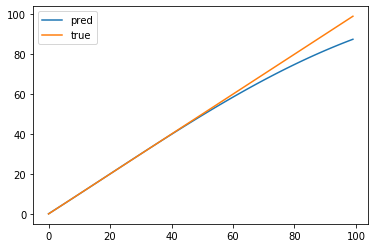

In [381]:
for _ in range(50):
    num_test_processes = 1
    gp_list, _, _ = get_sin_task_sequence(1, 1, num_test_processes, 0.1)

    x_train = np.arange(40)
    y_train = np.arange(40)
    gp_list[0][0].fit(np.atleast_2d(x_train).T, np.atleast_2d(y_train).T)

    x_points = np.atleast_2d(np.arange(100)).T
    pred, sigma = gp_list[0][0].predict(x_points, return_std=True)

plt.plot(x_points, pred, label="pred")
plt.plot(x_points, np.arange(100), label="true")
plt.legend()

In [190]:
for _ in range(10):
    num_test_processes = 1
    gp_list, _, _ = get_sin_task_sequence(1, 1, num_test_processes, 0.1)

    x_train = np.arange(40)
    y_train = np.arange(40)
    gp_list[0][0].fit(np.atleast_2d(x_train).T, np.atleast_2d(y_train).T)

    x_points = np.atleast_2d(np.arange(100)).T
    pred, sigma = gp_list[0][0].predict(x_points, return_std=True)

plt.plot(x_points, pred, label="pred")
plt.plot(x_points, np.arange(100), label="true")
plt.legend()

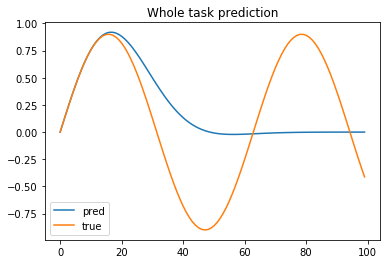

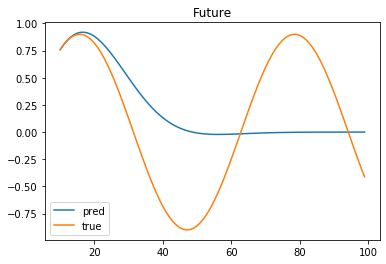

In [475]:
f = 0.1
a = 0.9
offset = 0. 
num_train_x = 10
num_horizon = 100

gp_list, _, _ = get_sin_task_sequence(0.001, 1, num_test_processes, 0.1)

x_train = np.arange(num_train_x)
y_train = a * np.sin(f*x_train)
gp_list[0][0].fit(np.atleast_2d(x_train).T, np.atleast_2d(y_train).T)

x_points = np.atleast_2d(np.arange(num_horizon)).T
pred, sigma = gp_list[0][0].predict(x_points, return_std=True)

plt.plot(x_points, pred, label="pred")
plt.plot(x_points, a*np.sin(f*np.arange(num_horizon)), label="true")
plt.legend()
plt.title("Whole task prediction")
plt.show()

plt.plot(x_points[num_train_x:], pred[num_train_x:], label="pred")
plt.plot(x_points[num_train_x:], a*np.sin(f*np.arange(num_horizon))[num_train_x:], label="true")
plt.legend()
plt.title("Future")
plt.show()

In [474]:
env = gym.make("CarRacing-v0")

AttributeError: module 'gym.envs.box2d' has no attribute 'CarRacing'

In [126]:
import torch
import numpy as np
import pickle

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Product, ConstantKernel as C

import gym_sin
from gym import spaces

from utilities.arguments import get_args
from learner.posterior_multi_task import PosteriorMTAgent
from inference.inference_network import InferenceNetwork
from task.ExploitTaskGenerator import ExploitTaskGenerator
from utilities.folder_management import handle_folder_creation


In [127]:
env_name = "exploit-v0"
action_space = spaces.Discrete(3)
latent_dim = 1
theta_min = -0.1
theta_max = 0.1
noise_var = 0.01

device = "cpu"
task_generator = ExploitTaskGenerator(noise_var=noise_var, theta_min=theta_min, theta_max=theta_max)
f = task_generator.create_task_family(n_tasks=5000, n_batches=1, test_perc=0, batch_size=1)

In [139]:
task_generator.sample_pair_tasks(1)

([{'noise_var': 0.01, 'theta': -0.10000000149011612}], None, [tensor([[0.0000],
          [0.1000]])], tensor([[-0.1000]]))

In [218]:
logvar_hat = (torch.ones(32, 1) * 0.4).log()
logvar_prior = (torch.ones(32, 1) * 20).log() 

mu_hat = torch.rand(32, 1)
mu_prior = mu_hat - 0.1

In [219]:
(torch.log(torch.prod(logvar_prior.exp(), 1) / torch.prod(logvar_hat.exp(), 1)))

tensor([3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120,
        3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120,
        3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120, 3.9120,
        3.9120, 3.9120, 3.9120, 3.9120, 3.9120])

In [220]:
(torch.sum(
        -1 + (mu_hat - mu_prior).pow(2) * (1 / logvar_prior.exp()) + (logvar_hat.exp() * (1 / logvar_prior.exp())), 1))


tensor([-0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795,
        -0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795,
        -0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795,
        -0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795, -0.9795])

In [233]:
c = 0
for _ in range(5000):
    r = torch.normal(torch.tensor([50.]), torch.tensor([20.])).item()
    if r < 0:
        c += 1
c

39

In [240]:
for i in range(10):
    if i < 10 - 1:
        print(i)
        

0
1
2
3
4
5
6
7
8


In [241]:
for i in range(10):
    print(i)
        

0
1
2
3
4
5
6
7
8
9


In [242]:
for iter in range(20):
    print(iter)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [244]:
envs

NameError: name 'envs' is not defined

In [268]:
min_friction = 0.065
max_friction = 0.196
prior_std_min = 0.001
prior_std_max = 0.05

num_processes = 4

In [280]:
ok = True
while ok:
    mu = (min_friction - max_friction) * torch.rand(num_processes) + max_friction
    std = (prior_std_min - prior_std_max) * torch.rand(num_processes) + prior_std_max

    new_tasks = torch.normal(mu, std).reshape(num_processes, 1)

    if torch.sum(new_tasks > max_friction) + torch.sum(new_tasks < min_friction) == 0:
        ok = False

prior = [torch.tensor([[mu[i]],[std[i]]]) for i in range(num_processes)]

In [297]:
prior[3]

tensor([[0.1735],
        [0.0039]])

In [298]:
c = torch.zeros(32, 14, 5)
obs = torch.ones((32, 3))

In [302]:
c[:, 0, 2:] = obs

In [304]:
c[:, 0]

tensor([[0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.]])

In [ ]:
import torch
import torch.nn.functional as F


class InferenceNetworkNew(torch.nn.Module):
    """
    Input:
        Previous latent space
        sequence of data from the current task and old task at that point
        prior over the current task (expressed as vector mu and c)

    Output:
        - sample from the probability distribution over the latent space
        - mu and logvar from the posterior distribution
    """

    def __init__(self, n_in, z_dim):
        super(InferenceNetwork, self).__init__()
        self.z_dim = z_dim
        self.n_in = n_in

        self.enc2 = torch.nn.GRU(input_size=n_in, hidden_size=32, num_layers=1, batch_first=True)
        self.enc3 = torch.nn.Linear(32 + z_dim * 2 + 1, 16)  # hidden + the prior + seq_len
        self.enc41 = torch.nn.Linear(16, z_dim)
        self.enc42 = torch.nn.Linear(16, z_dim)

        self.h = None
        self.seq_len = 0

    def encode(self, context, prior, use_prev_state):
        # Compute batch number and lenght of the sequence
        n_batch = context.shape[0]
        seq_len = context.shape[1]

        # Data preparation
        original_prior = prior
        if len(original_prior.shape) == 1:
            original_prior = original_prior.unsqueeze(0)
        prior = prior.reshape(n_batch, 1, 2)
        prior = prior.repeat(1, seq_len, 1)

        context = torch.cat([context, prior], dim=2).view(n_batch, seq_len, self.n_in)

        # Data processing
        if use_prev_state and self.h is not None:
            t, self.h = self.enc2(context, self.h)
        else:
            t, self.h = self.enc2(context)
        t = t[:, -1, :]  # we are interested only in the last output of the sequence
        t = F.elu(t)

        self.seq_len += seq_len
        trust = torch.tensor([self.seq_len], dtype=t.dtype).repeat(n_batch, 1)
        t = torch.cat([t, original_prior, trust], 1)
        t = F.elu(self.enc3(t))

        # Return encoded mu and logvar
        return self.enc41(t), self.enc42(t)

    def reparameterize(self, mu, logvar):
        # Re-parametrization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, context, prior, use_prev_state):
        if not use_prev_state:
            self.h = None
            self.seq_len = 0

        mu, logvar = self.encode(context, prior, use_prev_state)
        z = self.reparameterize(mu=mu, logvar=logvar)
        return z, mu, logvar


In [316]:
prev_state = torch.ones((16, 1), dtype=torch.bool)
for i in range(16):
    prev_state[i, 0] = np.random.binomial(n=1, p=0.5)

In [317]:
hn = torch.rand(1, 16, 32)

In [323]:
hn[0, prev_state.squeeze(1), :] = 0

In [326]:
hn[0,0,:]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [330]:
torch.logical_not(prev_state)

tensor([[False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [ True]])

array([-0.03587684, -0.03410754,  0.01189814,  0.00200269])

In [343]:
import gym
env = gym.make("CartPole-v0")
env.reset()
for i in range(150):
    a, r, d, _ = env.step(1)
    if d == True:
        env.reset()
        print(i)
        print(a)

8
[ 0.16927955  1.77576953 -0.24055599 -2.80429097]
16
[ 0.06704088  1.54581166 -0.21277598 -2.56989173]
25
[ 0.15901013  1.74361873 -0.22855912 -2.79840056]
35
[ 0.19894737  1.94736322 -0.21946133 -2.97884809]
44
[ 0.09704584  1.76173197 -0.24635658 -2.86659514]
54
[ 0.14127871  1.998918   -0.2146721  -2.9805171 ]
63
[ 0.14988865  1.77636818 -0.22454883 -2.80868439]
73
[ 0.20888934  1.9390127  -0.21817536 -2.99627614]
82
[ 0.17824009  1.73757791 -0.2232052  -2.81098757]
92
[ 0.15609591  1.97811273 -0.22621691 -3.01417999]
101
[ 0.10704379  1.77330509 -0.25256855 -2.85539394]
110
[ 0.14873064  1.72538509 -0.25905524 -2.89337132]
119
[ 0.10381458  1.74486331 -0.2273765  -2.77223515]
129
[ 0.15396771  1.94965583 -0.23940368 -3.04990413]
138
[ 0.10628405  1.73487182 -0.24729505 -2.84932096]
148
[ 0.19655252  1.93603939 -0.25165039 -3.05892511]


In [344]:
np.random.rand()

0.8377280415990496

In [345]:
layer = torch.nn.GRU(input_size=3, hidden_size=32, num_layers=1, batch_first=True)

In [347]:
t = torch.rand(15, 10, 3)

In [375]:
#ended = torch.zeros(32, dtype=torch.bool)
done = torch.zeros((32, 1), dtype=torch.bool)
done[3] = True
done[6] = True
done[10] = True
done[15] = True

In [368]:
ended = (~torch.eq(ended, done.squeeze(1))) & (~torch.eq(ended, done.squeeze(1)))
ended

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])

In [376]:
ended = ended | done.squeeze(1)

In [377]:
ended

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True])

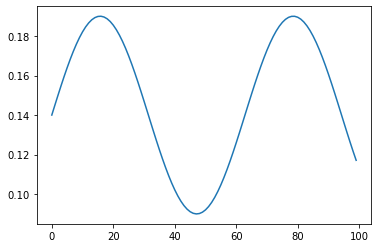

In [423]:
x = np.arange(100)
min_friction = 0.065
max_friction = 0.196

f = 0.1
a = 0.0655
offset = 0.14
a=0.05
y = a * np.sin(f * x) + offset

plt.plot(x, y)

In [424]:
y.max()

0.18997868015207528

0.0655

In [425]:
25000/250

100.0

In [426]:
12500/250

50.0

In [427]:
12500/125

100.0

(array([ 1.,  0.,  0.,  6.,  7., 11., 14.,  5.,  4.,  2.]),
 array([-0.99171233, -0.83254737, -0.67338241, -0.51421746, -0.3550525 ,
        -0.19588754, -0.03672259,  0.12244237,  0.28160733,  0.44077229,
         0.59993724]),
 <a list of 10 Patch objects>)

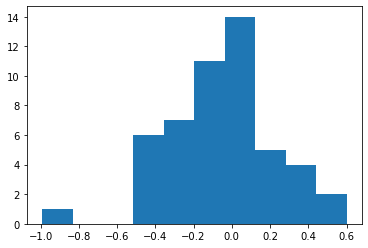

In [442]:
t = np.random.normal(0, 0.3, size=50)
plt.hist(t)

In [469]:
(0.196 - 0.065) / (1 - (-1)) * (1 - 1) + 0.196

0.196

In [465]:
def _rescale_action(action, max_new, min_new):
    if max_new is not None or min_new is not None:
        return (max_new - min_new) / (1 - (-1)) * (action - 1) + max_new
    else:
        return action

In [466]:
_rescale_action(1, 0.196, 0.065)

0.196

In [476]:
from gym import spaces

In [481]:

high_act = np.array([
    1,
    np.pi,
], dtype=np.float32)

low_act = np.array([
    0,
    -np.pi
], dtype=np.float32)

action_space = spaces.Box(low=low_act, high=high_act)

In [479]:
action_space

Box(2,)

In [484]:
size = 10
state_x = np.random.uniform(low=-size, high=size, size=1)[0]
state_y = np.random.uniform(low=-size, high=size, size=1)[0]
direction = np.random.uniform(low=0, high=np.pi, size=1)[0]
(state_x, state_y, direction)

(0.08983764436808706, -1.282557881132746, 0.8915582422171423)

In [3]:
import numpy as np

In [2]:
action = (1, 5)

In [4]:
np.sqrt(0.05)

0.22360679774997896

In [5]:
import torch

In [13]:
min_v = torch.zeros(5)
max_v = torch.ones(5)

sample = torch.rand(3, 5)

In [14]:
sample

tensor([[0.8644, 0.3661, 0.4337, 0.7655, 0.0068],
        [0.9592, 0.3910, 0.7011, 0.2496, 0.7226],
        [0.4816, 0.9849, 0.3614, 0.4741, 0.8491]])

In [15]:
(min_v - max_v) * sample + max_v

tensor([[0.1356, 0.6339, 0.5663, 0.2345, 0.9932],
        [0.0408, 0.6090, 0.2989, 0.7504, 0.2774],
        [0.5184, 0.0151, 0.6386, 0.5259, 0.1509]])

In [254]:
import torch

from task.task_generator import TaskGenerator


class GridWorldTaskGenerator(TaskGenerator):

    def __init__(self, size, goal_radius, charge_forward_min, charge_forward_max,
                 charge_rotation_min, charge_rotation_max, prior_goal_std_min,
                 prior_goal_std_max, prior_charge_std_min, prior_charge_std_max):
        super(GridWorldTaskGenerator, self).__init__()

        self.latent_dim = 5

        # Fixed env setting
        self.size = size
        self.goal_radius = goal_radius

        # Env latent space
        goal_max = size / 2
        goal_min = -size / 2

        self.latent_min_mean = torch.tensor([goal_min, goal_min, charge_forward_min,
                                             charge_rotation_min, charge_rotation_min], dtype=torch.float32)
        self.latent_max_mean = torch.tensor([goal_max, goal_max, charge_forward_max,
                                             charge_rotation_max, charge_rotation_max], dtype=torch.float32)
        self.latent_min_std = torch.tensor([prior_goal_std_min, prior_goal_std_min, prior_charge_std_min,
                                            prior_charge_std_min, prior_charge_std_max], dtype=torch.float32)
        self.latent_max_std = torch.tensor([prior_goal_std_max, prior_goal_std_max, prior_charge_std_max,
                                            prior_charge_std_max, prior_charge_std_max], dtype=torch.float32)

    def create_task_family(self, n_tasks, n_batches=1, test_perc=0, batch_size=160):
        raise NotImplemented

    def sample_task_from_prior(self, prior):
        ok = True
        while ok:
            mu = prior[0].clone().detach()
            var = prior[1].clone().detach()

            task_param = torch.normal(mu, var)

            if torch.sum(task_param > self.latent_max_mean) + torch.sum(task_param < self.latent_min_mean) == 0:
                ok = False

        envs_kwargs = {'size': self.size,
                       'goal_x': task_param[0].item(),
                       'goal_y': task_param[1].item(),
                       'goal_radius': self.goal_radius,
                       'charge_forward': task_param[2].item(),
                       'charge_left': task_param[3].item(),
                       'charge_right': task_param[4].item()}

        return envs_kwargs

    def sample_pair_tasks(self, num_p):
        mu = (self.latent_min_mean - self.latent_max_mean) * torch.rand(num_p, self.latent_dim) + self.latent_max_mean
        std = (self.latent_min_std - self.latent_max_std) * torch.rand(num_p, self.latent_dim) + self.latent_max_std
        new_tasks = torch.normal(mu, std).reshape(num_p, self.latent_dim)
        not_ok_task = torch.any(new_tasks > self.latent_max_mean, 1) | torch.any(new_tasks < self.latent_min_mean, 1)

        while torch.sum(not_ok_task) != 0:
            temp_new_tasks = torch.normal(mu, std).reshape(num_p, self.latent_dim)

            new_tasks[not_ok_task, :] = temp_new_tasks[not_ok_task]
            not_ok_task = (
                        torch.any(new_tasks > self.latent_max_mean, 1) | torch.any(new_tasks < self.latent_min_mean, 1))

        prior = [torch.tensor([mu[i].tolist(), std[i].tolist()]) for i in range(1)]

        envs_kwargs = [{'size': self.size,
                        'goal_x': new_tasks[i][0].item(),
                        'goal_y': new_tasks[i][1].item(),
                        'goal_radius': self.goal_radius,
                        'charge_forward': new_tasks[i][2].item(),
                        'charge_left': new_tasks[i][3].item(),
                        'charge_right': new_tasks[i][4].item()}
                       for i in range(num_p)]

        return envs_kwargs, None, prior, new_tasks


In [255]:
task_gen = GridWorldTaskGenerator(size=8,
                                      goal_radius=0.2, 
                                      charge_forward_min=0.5, 
                                      charge_forward_max=1,
                                      charge_rotation_min=0.2, 
                                      charge_rotation_max=1, 
                                      prior_goal_std_min=0.1,
                                      prior_goal_std_max=2,
                                      prior_charge_std_min=0.01,
                                      prior_charge_std_max=0.1)

In [256]:
p = task_gen.sample_pair_tasks(1)[2]

In [257]:
task_gen.sample_task_from_prior(p[0])

{'size': 8,
 'goal_x': 0.39852774143218994,
 'goal_y': -1.3080995082855225,
 'goal_radius': 0.2,
 'charge_forward': 0.8743904232978821,
 'charge_left': 0.48559799790382385,
 'charge_right': 0.4825255572795868}

In [1]:
import gym
import gym_sin

In [2]:
env = gym.make("gridworld-v0", size=8, goal_x=1, goal_y=1, goal_radius=0.1, charge_left=1, charge_right=1, charge_forward=1)

In [11]:
env.reset()

array([[0., 0., 0.]])

In [24]:
env.step([1, -1])

(array([[-0.77588656, -1.26040974,  4.6467545 ]]),
 -2.874582622926011,
 False,
 {})

In [10]:
env.get_state()

array([[2.58226164, 7.73038885, 2.51096954]])

In [9]:
env.state

(0.0, 0.0, 0.0)

In [8]:
env.state = (0., 0., 0.)

In [25]:
import torch

In [26]:
context = torch.empty(32, 15, 1+1)

In [29]:
context[:, 0, 1].shape

torch.Size([32])